# Fitting a distribution to the full trap GSD

In [1]:
import numpy as np
import pandas as pd
from scipy.interpolate import PchipInterpolator
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde


### Testing (one distribution, to later apply to all)

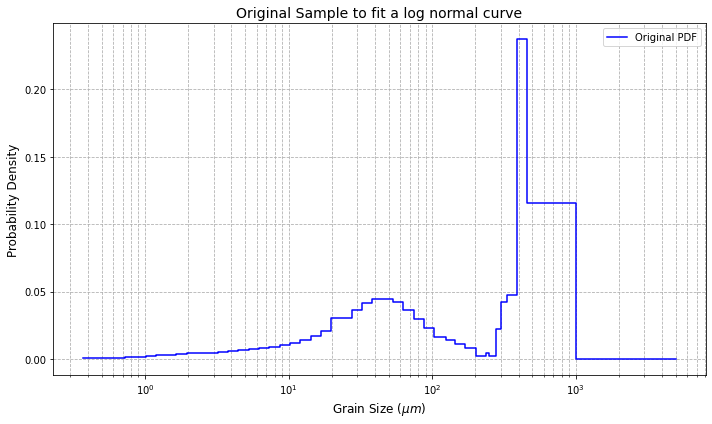

In [2]:
df = pd.read_csv('SM_trap_full_PDF.csv')
grain_sizes = df['Di (um)'].values
percentages = df['T1-A'].values

# plot raw data
plt.figure(figsize=(10, 6))
plt.step(grain_sizes, percentages, label='Original PDF', color='blue')

plt.xscale('log')
plt.xlabel('Grain Size ($\mu m$)', fontsize=12)
plt.ylabel('Probability Density', fontsize=12)
plt.title('Original Sample to fit a log normal curve', fontsize=14)
plt.legend()
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()

In [3]:
def log_cubic_psd(particle_size, percentages, num_total_points=100): 
# this is based off the procedure from http://dx.doi.org/10.1155/2013/579460
    d_measured = particle_size
    P_measured = percentages
    # using natural logarithm as in the paper's equations (lnd).
    ln_d_measured = np.log(d_measured)
    # monotone piecewise cubic interpolation method
    pchip_interpolator = PchipInterpolator(ln_d_measured, P_measured)
    # single array of linearly spaced points in the logarithmic domain.
    ln_d_interpolated = np.linspace(ln_d_measured.min(), ln_d_measured.max(), num_total_points)
    # interpolate cumulative percentages using the PCHIP interpolator.
    P_interpolated = pchip_interpolator(ln_d_interpolated)
    # convert the interpolated logarithm of particle size back to the original scale.
    d_interpolated = np.exp(ln_d_interpolated)
    # normalize to ensure the total percentage sums to 1
    P_interpolated_normalized = P_interpolated / np.sum(P_interpolated)

    return d_interpolated, P_interpolated_normalized

def interpolate_pdf_spline(particle_size, percentages, num_total_points=100):
    """
    Interpolates a particle size distribution (PDF) using a cubic spline in the
    logarithmic domain to ensure proper scaling and smoothness.
    """
    # Use natural logarithm for particle sizes as in the paper
    ln_d_measured = np.log(particle_size)
    
    # Use a standard CubicSpline for smooth interpolation of a PDF.
    # It does not enforce monotonicity like PchipInterpolator.
    cubic_spline_interpolator = CubicSpline(ln_d_measured, percentages)
    
    # Create a new, denser array of points in the logarithmic domain
    ln_d_interpolated = np.linspace(ln_d_measured.min(), ln_d_measured.max(), num_total_points)
    
    # Interpolate the percentages using the cubic spline
    P_interpolated = cubic_spline_interpolator(ln_d_interpolated)
    
    # Ensure all interpolated percentages are non-negative
    P_interpolated[P_interpolated < 0] = 0
    
    # Normalize to ensure the total percentage sums to 1 (a requirement for a PDF)
    P_interpolated_normalized = P_interpolated / np.sum(P_interpolated)
    
    # Convert the interpolated log of particle size back to the original scale
    d_interpolated = np.exp(ln_d_interpolated)
    
    return d_interpolated, P_interpolated_normalized

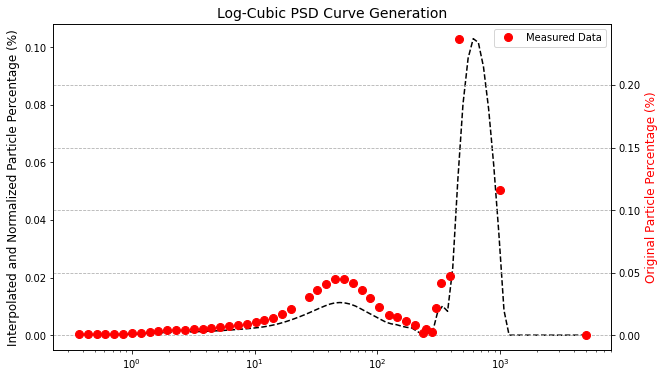

In [4]:
# interpolate raw data
#interpolated_grain_sizes, interpolated_percentages = log_cubic_psd(grain_sizes, percentages, num_total_points=100)
interpolated_grain_sizes, interpolated_percentages = interpolate_pdf_spline(grain_sizes, percentages, num_total_points=100)
plt.figure(figsize=(10, 6))
plt.semilogx(interpolated_grain_sizes, interpolated_percentages, '--', label='Log-Cubic Curve (Interpolated)', color='black')
plt.ylabel('Interpolated and Normalized Particle Percentage (%)', fontsize=12)
# twin y axis
ax2 = plt.gca().twinx()
ax2.semilogx(grain_sizes, percentages, 'o', label='Measured Data', color='red', markersize=8)
plt.xlabel('Particle Size ($\mu$m)', fontsize=12)
plt.ylabel('Original Particle Percentage (%)', fontsize=12, color='red')
plt.title('Log-Cubic PSD Curve Generation', fontsize=14)
plt.grid(True, which="both", ls="--")
plt.legend()
plt.show()

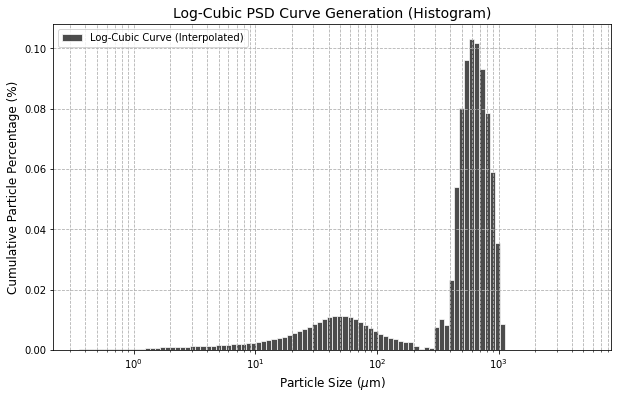

In [6]:
# plot as histogram
plt.figure(figsize=(10, 6))

# calculate bin widths for log-scale histogram 
log_grain_sizes_interp = np.log10(interpolated_grain_sizes)
bin_widths_interp = np.diff(log_grain_sizes_interp)
bin_widths_interp = np.append(bin_widths_interp, bin_widths_interp[-1])  # extend for last bin
actual_widths_interp = 10**(log_grain_sizes_interp + bin_widths_interp/2) - 10**(log_grain_sizes_interp - bin_widths_interp/2)

plt.bar(interpolated_grain_sizes, interpolated_percentages, width=actual_widths_interp, 
        alpha=0.7, label='Log-Cubic Curve (Interpolated)', color='black', edgecolor='white')

plt.xscale('log')
plt.xlabel('Particle Size ($\mu$m)', fontsize=12)
plt.ylabel('Cumulative Particle Percentage (%)', fontsize=12)
plt.title('Log-Cubic PSD Curve Generation (Histogram)', fontsize=14)
plt.grid(True, which="both", ls="--")
plt.legend()
plt.show()


In [5]:
# Fit KDE to the interpolated data
log_grain_sizes_kde = np.log10(interpolated_grain_sizes) # log-transform the grain sizes
# create sample points weighted by their percentages for KDE
sample_weights = (interpolated_percentages * 1000).astype(int)  # scale up and convert to int
kde_samples = np.repeat(log_grain_sizes_kde, sample_weights)
kde = gaussian_kde(kde_samples) # fit KDE
# generate smooth curve for plotting
log_x_smooth = np.linspace(log_grain_sizes_kde.min(), log_grain_sizes_kde.max(), 100)
x_smooth = 10**log_x_smooth
kde_density = kde(log_x_smooth)
kde_density_scaled = kde_density * np.trapz(interpolated_percentages, log_grain_sizes_kde) / np.trapz(kde_density, log_x_smooth)

In [6]:
# Fit KDE to the interpolated data
log_grain_sizes_kde = np.log10(grain_sizes) # log-transform the grain sizes
# create sample points weighted by their percentages for KDE
sample_weights = (percentages * 1000).astype(int)  # scale up and convert to int
kde_samples = np.repeat(log_grain_sizes_kde, sample_weights)
kde = gaussian_kde(kde_samples) # fit KDE
# generate smooth curve for plotting
log_x_smooth_data = np.linspace(log_grain_sizes_kde.min(), log_grain_sizes_kde.max(), 100)
x_smooth_data = 10**log_x_smooth_data
kde_density_data = kde(log_x_smooth_data)
kde_density_scaled_data = kde_density_data * np.trapz(percentages, log_grain_sizes_kde) / np.trapz(kde_density_data, log_x_smooth_data)

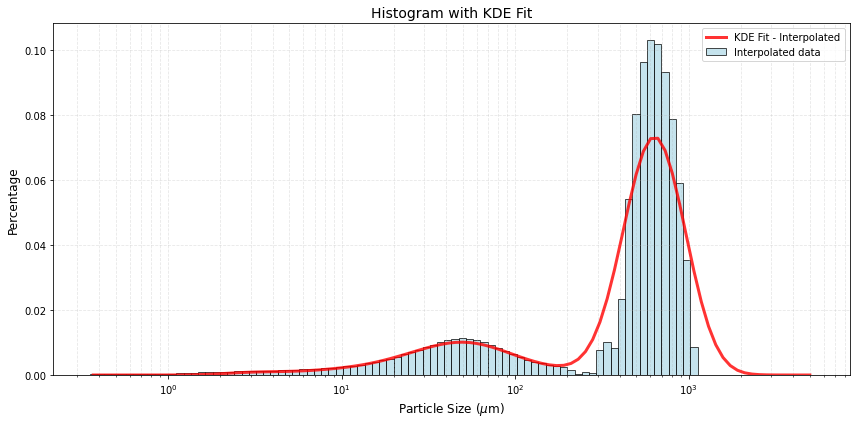

In [11]:
# plot histogram with KDE overlay
plt.figure(figsize=(12, 6))

# original histogram
log_grain_sizes_interp = np.log10(interpolated_grain_sizes)
bin_widths_interp = np.diff(log_grain_sizes_interp)
bin_widths_interp = np.append(bin_widths_interp, bin_widths_interp[-1])
actual_widths_interp = 10**(log_grain_sizes_interp + bin_widths_interp/2) - 10**(log_grain_sizes_interp - bin_widths_interp/2)
plt.bar(interpolated_grain_sizes, interpolated_percentages, width=actual_widths_interp, 
        alpha=0.7, label='Interpolated data', color='lightblue', edgecolor='black')
# KDE curve
plt.plot(x_smooth, kde_density_scaled, 'r-', linewidth=3, label='KDE Fit - Interpolated', alpha=0.8)
# twin axis
#ax = plt.gca().twinx()
#ax.step(grain_sizes, percentages, label='Original PDF', color='blue')
#ax.plot(x_smooth_data, kde_density_scaled_data, 'g-', linewidth=3, label='KDE Fit - Original', alpha=0.8)

plt.xscale('log')
plt.xlabel('Particle Size ($\mu$m)', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.title('Histogram with KDE Fit', fontsize=14)
plt.grid(True, which="both", ls="--", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
# print the sum of kde density scaled
print(kde_density_scaled.sum())
print(kde_density_scaled_data.sum())

0.9998964170032092
3.7183766713420865


### Automate for all other samples

Import data

In [12]:
trap_SM = pd.read_csv("SM_trap_full_PDF.csv")
trap_SP = pd.read_csv("SP_trap_full_PDF.csv")
grain_sizes = trap_SM['Di (um)'].values

In [13]:
# check the sum of columns (each sample percentage)
print("Sum (Trap SM):", trap_SM.iloc[:, 1:].sum())
print("Sum (Trap SP):", trap_SP.iloc[:, 1:].sum())

Sum (Trap SM): T1-A    1.000000
T1-B    1.000000
T1-C    1.000000
T1-D    1.000000
T2-A    1.000000
T2-B    1.000000
T3-C    1.000000
T3-D    1.000000
T5-A    1.000000
T5-B    1.000000
T5-C    1.000037
T5-D    1.000000
T6-B    0.999938
T6-C    1.000000
T6-D    1.000000
T7-A    1.000000
T7-B    1.000000
T7-C    1.000000
T7-D    1.000000
T8-A    1.000000
T8-C    1.000000
T8-D    1.000000
dtype: float64
Sum (Trap SP): T1-A    1.0
T1-B    1.0
T1-C    1.0
T1-D    1.0
T2-A    1.0
T2-B    1.0
T3-C    1.0
T3-D    1.0
T5-A    1.0
T5-B    1.0
T5-C    1.0
T5-D    1.0
T6-A    1.0
T6-B    1.0
T6-C    1.0
T6-D    1.0
T7-A    1.0
T7-B    1.0
T7-C    1.0
T7-D    1.0
T8-A    1.0
T8-C    1.0
T8-D    1.0
dtype: float64


Interpolate for all samples

In [14]:
# initialize with the grain sizes
#d_interpolated, _ = log_cubic_psd(grain_sizes, percentages) # da lo mismo el porcentage
d_interpolated, _ = interpolate_pdf_spline(grain_sizes, percentages, num_total_points=100)
trap_SM_interpolated = pd.DataFrame({'grain_size': d_interpolated})
trap_SP_interpolated = pd.DataFrame({'grain_size': d_interpolated})

# loop through each sample column 
for col in trap_SM.columns[1:]: # skipping first column bc its grain size
    #_, P_interpolated = log_cubic_psd(grain_sizes, trap_SM[col])
    _, P_interpolated = interpolate_pdf_spline(grain_sizes, trap_SM[col])
    # add the new column to the dataframe
    trap_SM_interpolated[f'{col}_interpolated'] = P_interpolated

for col in trap_SP.columns[1:]: # skipping first column bc its grain size
    #_, P_interpolated = log_cubic_psd(grain_sizes, trap_SP[col])
    _, P_interpolated = interpolate_pdf_spline(grain_sizes, trap_SP[col])
    # add the new column to the dataframe
    trap_SP_interpolated[f'{col}_interpolated'] = P_interpolated

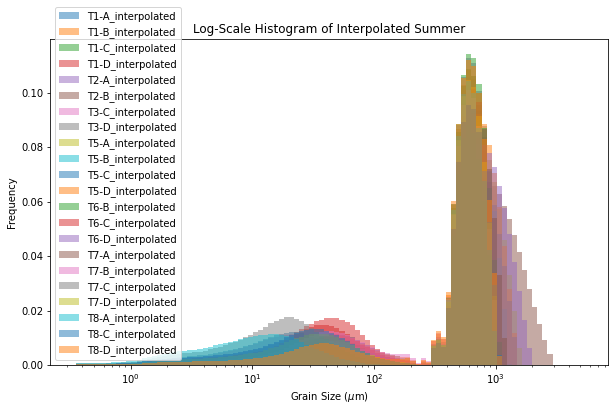

In [15]:
# calculate bin widths for log-scale histogram 
log_grain_sizes_interp = np.log10(interpolated_grain_sizes)
bin_widths_interp = np.diff(log_grain_sizes_interp)
bin_widths_interp = np.append(bin_widths_interp, bin_widths_interp[-1])  # extend for last bin
actual_widths_interp = 10**(log_grain_sizes_interp + bin_widths_interp/2) - 10**(log_grain_sizes_interp - bin_widths_interp/2)

# plot as histogram
plt.figure(figsize=(10, 6))
for col in trap_SM_interpolated.columns[1:]:
    plt.bar(trap_SM_interpolated['grain_size'], trap_SM_interpolated[col], width=actual_widths_interp, 
            label=col, alpha=0.5)
plt.xscale('log')
plt.title('Log-Scale Histogram of Interpolated Summer')
plt.xlabel('Grain Size ($\mu$m)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

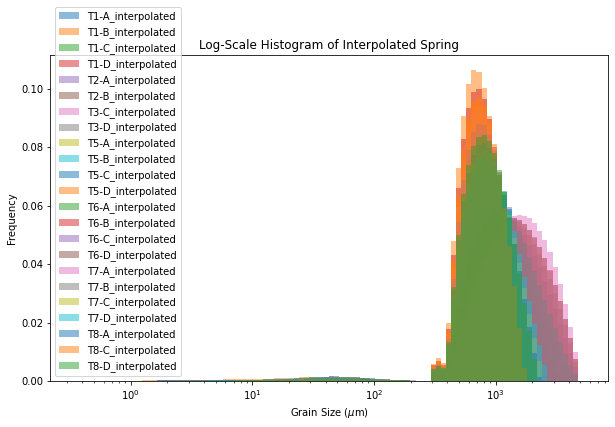

In [16]:
# plot as histogram
plt.figure(figsize=(10, 6))
for col in trap_SP_interpolated.columns[1:]:
    plt.bar(trap_SP_interpolated['grain_size'], trap_SP_interpolated[col], width=actual_widths_interp, 
            label=col, alpha=0.5)
plt.xscale('log')
plt.title('Log-Scale Histogram of Interpolated Spring')
plt.xlabel('Grain Size ($\mu$m)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [17]:
# check the sum of columns (each sample percentage)
print("Sum (Trap SM):", trap_SM_interpolated.iloc[:, 1:].sum())
print("Sum (Trap SP):", trap_SP_interpolated.iloc[:, 1:].sum())

Sum (Trap SM): T1-A_interpolated    1.0
T1-B_interpolated    1.0
T1-C_interpolated    1.0
T1-D_interpolated    1.0
T2-A_interpolated    1.0
T2-B_interpolated    1.0
T3-C_interpolated    1.0
T3-D_interpolated    1.0
T5-A_interpolated    1.0
T5-B_interpolated    1.0
T5-C_interpolated    1.0
T5-D_interpolated    1.0
T6-B_interpolated    1.0
T6-C_interpolated    1.0
T6-D_interpolated    1.0
T7-A_interpolated    1.0
T7-B_interpolated    1.0
T7-C_interpolated    1.0
T7-D_interpolated    1.0
T8-A_interpolated    1.0
T8-C_interpolated    1.0
T8-D_interpolated    1.0
dtype: float64
Sum (Trap SP): T1-A_interpolated    1.0
T1-B_interpolated    1.0
T1-C_interpolated    1.0
T1-D_interpolated    1.0
T2-A_interpolated    1.0
T2-B_interpolated    1.0
T3-C_interpolated    1.0
T3-D_interpolated    1.0
T5-A_interpolated    1.0
T5-B_interpolated    1.0
T5-C_interpolated    1.0
T5-D_interpolated    1.0
T6-A_interpolated    1.0
T6-B_interpolated    1.0
T6-C_interpolated    1.0
T6-D_interpolated    1.0
T7-A_

### Summer

Fit KDE to the interpolated sizes

In [18]:
for col in trap_SM_interpolated.columns[1:]:
    print(f"KDE for column: {col}")
    interpolated_percentages = trap_SM_interpolated[col].values
    # fit kde to the data
    log_grain_sizes_kde = np.log10(interpolated_grain_sizes) # log-transform the grain sizes
    # create sample points weighted by their percentages for KDE
    sample_weights = (interpolated_percentages * 1000).astype(int)  # scale up and convert to int
    kde_samples = np.repeat(log_grain_sizes_kde, sample_weights)
    kde = gaussian_kde(kde_samples)
    # scale kde data to match the original
    log_x_smooth = np.linspace(log_grain_sizes_kde.min(), log_grain_sizes_kde.max(), 100)
    x_smooth = 10**log_x_smooth
    kde_density = kde(log_x_smooth)
    kde_density_scaled = kde_density * np.trapz(interpolated_percentages, log_grain_sizes_kde) / np.trapz(kde_density, log_x_smooth)

    # save the kde density to the dataframe
    trap_SM_interpolated[f'{col}_kde'] = kde_density_scaled

KDE for column: T1-A_interpolated
KDE for column: T1-B_interpolated
KDE for column: T1-C_interpolated
KDE for column: T1-D_interpolated
KDE for column: T2-A_interpolated
KDE for column: T2-B_interpolated
KDE for column: T3-C_interpolated
KDE for column: T3-D_interpolated
KDE for column: T5-A_interpolated
KDE for column: T5-B_interpolated
KDE for column: T5-C_interpolated
KDE for column: T5-D_interpolated
KDE for column: T6-B_interpolated
KDE for column: T6-C_interpolated
KDE for column: T6-D_interpolated
KDE for column: T7-A_interpolated
KDE for column: T7-B_interpolated
KDE for column: T7-C_interpolated
KDE for column: T7-D_interpolated
KDE for column: T8-A_interpolated
KDE for column: T8-C_interpolated
KDE for column: T8-D_interpolated


Plot and store KDEs for each sample

In [19]:
# loop through all interpolated samples and create plots
sns.set(style="darkgrid")
for col in trap_SM_interpolated.columns[1:]:
    if col.endswith('_interpolated'):  # just the interpolated columns
        kde_col = f'{col}_kde' # get the corresponding KDE column
        if kde_col in trap_SM_interpolated.columns:
            # get the data
            interpolated_percentages_sample = trap_SM_interpolated[col].values
            kde_density_scaled = trap_SM_interpolated[kde_col].values
            grain_sizes_sample = trap_SM_interpolated['grain_size'].values
            
            # create the plot
            plt.figure(figsize=(12, 6))
            # calculate bin widths for histogram
            log_grain_sizes_interp = np.log10(grain_sizes_sample)
            bin_widths_interp = np.diff(log_grain_sizes_interp)
            bin_widths_interp = np.append(bin_widths_interp, bin_widths_interp[-1])
            actual_widths_interp = 10**(log_grain_sizes_interp + bin_widths_interp/2) - 10**(log_grain_sizes_interp - bin_widths_interp/2)
            
            # plot histogram
            plt.bar(grain_sizes_sample, interpolated_percentages_sample, 
                    width=actual_widths_interp, alpha=0.7, label='Interpolated data', 
                    color='palegreen', edgecolor='black')
            # plot pre-calculated KDE curve
            plt.plot(grain_sizes_sample, kde_density_scaled, color='forestgreen', linewidth=3, label='KDE Fit', alpha=0.8)
            
            plt.xscale('log')
            plt.xlabel('Particle Size ($\mu$m)', fontsize=12)
            plt.ylabel('Percentage', fontsize=12)
            plt.title(f'Summer - Histogram with KDE Fit - {col}', fontsize=14)
            plt.grid(True, which="both", ls="--", alpha=0.3)
            plt.legend()
            plt.tight_layout()
            
            # save figure
            plt.savefig(f'bimodal_fit_plots/SM_{col}_kde_fit.png', dpi=300, bbox_inches='tight')
            plt.close()  # Close the figure to free memory
        else:
            print(f"Warning: KDE column {kde_col} not found for {col}")


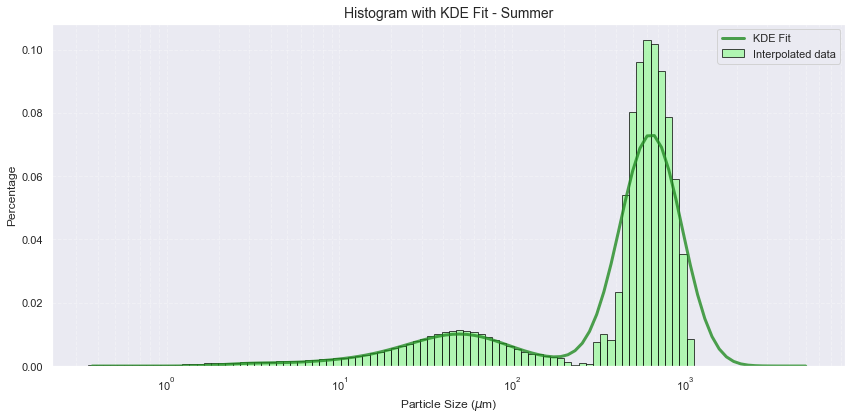

In [20]:
# plot histogram with KDE overlay
plt.figure(figsize=(12, 6))

# original histogram
log_grain_sizes_interp = np.log10(interpolated_grain_sizes)
bin_widths_interp = np.diff(log_grain_sizes_interp)
bin_widths_interp = np.append(bin_widths_interp, bin_widths_interp[-1])
actual_widths_interp = 10**(log_grain_sizes_interp + bin_widths_interp/2) - 10**(log_grain_sizes_interp - bin_widths_interp/2)
plt.bar(trap_SM_interpolated['grain_size'], trap_SM_interpolated['T1-A_interpolated'], width=actual_widths_interp, 
        alpha=0.7, label='Interpolated data', color='palegreen', edgecolor='black')
# KDE curve
plt.plot(trap_SM_interpolated['grain_size'], trap_SM_interpolated['T1-A_interpolated_kde'], color='forestgreen', linewidth=3, label='KDE Fit', alpha=0.8)

plt.xscale('log')
plt.xlabel('Particle Size ($\mu$m)', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.title('Histogram with KDE Fit - Summer', fontsize=14)
plt.grid(True, which="both", ls="--", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [21]:
# print the sum of the kde densities
for col in trap_SM_interpolated.columns[1:]:
    if col.endswith('_kde'):
        kde_sum = trap_SM_interpolated[col].sum()
        print(f"Sum of {col}: {kde_sum}")

Sum of T1-A_interpolated_kde: 0.9998964170032092
Sum of T1-B_interpolated_kde: 0.9998917499677137
Sum of T1-C_interpolated_kde: 0.9998972148479591
Sum of T1-D_interpolated_kde: 0.9998099575686638
Sum of T2-A_interpolated_kde: 0.9999064960698469
Sum of T2-B_interpolated_kde: 1.0000280841344567
Sum of T3-C_interpolated_kde: 0.9998168928166725
Sum of T3-D_interpolated_kde: 0.999906563525431
Sum of T5-A_interpolated_kde: 0.9999089978786333
Sum of T5-B_interpolated_kde: 0.9998933192308357
Sum of T5-C_interpolated_kde: 0.9998437478569018
Sum of T5-D_interpolated_kde: 0.9998851681081026
Sum of T6-B_interpolated_kde: 0.9998957355717034
Sum of T6-C_interpolated_kde: 0.9998131495751049
Sum of T6-D_interpolated_kde: 0.9999419379314333
Sum of T7-A_interpolated_kde: 0.9999064834349578
Sum of T7-B_interpolated_kde: 0.9998729792334597
Sum of T7-C_interpolated_kde: 0.9997459080912435
Sum of T7-D_interpolated_kde: 0.9998591220931663
Sum of T8-A_interpolated_kde: 0.9997576198785453
Sum of T8-C_interpola

### Spring

Fit KDE to the interpolated sizes

In [22]:
for col in trap_SP_interpolated.columns[1:]:
    print(f"KDE for column: {col}")
    interpolated_percentages = trap_SP_interpolated[col].values
    # fit kde to the data
    log_grain_sizes_kde = np.log10(interpolated_grain_sizes) # log-transform the grain sizes
    # create sample points weighted by their percentages for KDE
    sample_weights = (interpolated_percentages * 1000).astype(int)  # scale up and convert to int
    kde_samples = np.repeat(log_grain_sizes_kde, sample_weights)
    kde = gaussian_kde(kde_samples)
    # scale kde data to match the original
    log_x_smooth = np.linspace(log_grain_sizes_kde.min(), log_grain_sizes_kde.max(), 100)
    x_smooth = 10**log_x_smooth
    kde_density = kde(log_x_smooth)
    kde_density_scaled = kde_density * np.trapz(interpolated_percentages, log_grain_sizes_kde) / np.trapz(kde_density, log_x_smooth)

    # save the kde density to the dataframe
    trap_SP_interpolated[f'{col}_kde'] = kde_density_scaled

KDE for column: T1-A_interpolated
KDE for column: T1-B_interpolated
KDE for column: T1-C_interpolated
KDE for column: T1-D_interpolated


KDE for column: T2-A_interpolated
KDE for column: T2-B_interpolated
KDE for column: T3-C_interpolated
KDE for column: T3-D_interpolated
KDE for column: T5-A_interpolated
KDE for column: T5-B_interpolated
KDE for column: T5-C_interpolated
KDE for column: T5-D_interpolated
KDE for column: T6-A_interpolated
KDE for column: T6-B_interpolated
KDE for column: T6-C_interpolated
KDE for column: T6-D_interpolated
KDE for column: T7-A_interpolated
KDE for column: T7-B_interpolated
KDE for column: T7-C_interpolated
KDE for column: T7-D_interpolated
KDE for column: T8-A_interpolated
KDE for column: T8-C_interpolated
KDE for column: T8-D_interpolated


Plot and store KDEs for each sample

In [23]:
# loop through all interpolated samples and create plots
sns.set(style="darkgrid")
for col in trap_SP_interpolated.columns[1:]:
    if col.endswith('_interpolated'):  # just the interpolated columns
        kde_col = f'{col}_kde' # get the corresponding KDE column
        if kde_col in trap_SP_interpolated.columns:
            # get the data
            interpolated_percentages_sample = trap_SP_interpolated[col].values
            kde_density_scaled = trap_SP_interpolated[kde_col].values
            grain_sizes_sample = trap_SP_interpolated['grain_size'].values
            # create the plot
            plt.figure(figsize=(12, 6))
            # calculate bin widths for histogram
            log_grain_sizes_interp = np.log10(grain_sizes_sample)
            bin_widths_interp = np.diff(log_grain_sizes_interp)
            bin_widths_interp = np.append(bin_widths_interp, bin_widths_interp[-1])
            actual_widths_interp = 10**(log_grain_sizes_interp + bin_widths_interp/2) - 10**(log_grain_sizes_interp - bin_widths_interp/2)
            
            # plot histogram
            plt.bar(grain_sizes_sample, interpolated_percentages_sample, 
                    width=actual_widths_interp, alpha=0.7, label='Interpolated data', 
                    color='powderblue', edgecolor='black')
            # plot pre-calculated KDE curve
            plt.plot(grain_sizes_sample, kde_density_scaled, color='steelblue', linewidth=3, label='KDE Fit', alpha=0.8)
            
            plt.xscale('log')
            plt.xlabel('Particle Size ($\mu$m)', fontsize=12)
            plt.ylabel('Percentage', fontsize=12)
            plt.title(f'Spring - Histogram with KDE Fit - {col}', fontsize=14)
            plt.grid(True, which="both", ls="--", alpha=0.3)
            plt.legend()
            plt.tight_layout()
            
            # save figure
            plt.savefig(f'bimodal_fit_plots/SP_{col}_kde_fit.png', dpi=300, bbox_inches='tight')
            plt.close()  # Close the figure to free memory
        else:
            print(f"Warning: KDE column {kde_col} not found for {col}")


### Bedload

In [24]:
bedload = pd.read_csv("bedload/bedload_samples.csv")
grain_sizes = bedload['Di (um)'].values

In [25]:
print("Sum (Bedload):", bedload.iloc[:, 1:].sum())  

Sum (Bedload): #3     1.0
#4     1.0
#5     1.0
#6     1.0
#7     1.0
#8     1.0
#9     1.0
#10    1.0
dtype: float64


Interpolate for all samples

In [26]:
# initialize with the grain sizes
#d_interpolated, _ = log_cubic_psd(grain_sizes, bedload["#3"]) # da lo mismo el porcentage
d_interpolated, _ = interpolate_pdf_spline(grain_sizes, bedload["#3"])
bedload_interpolated = pd.DataFrame({'grain_size': d_interpolated})

# loop through each sample column
for col in bedload.columns[1:]:  # skipping first column bc its grain size
    _, P_interpolated = interpolate_pdf_spline(grain_sizes, bedload[col])
    # add the new column to the dataframe
    bedload_interpolated[f'{col}_interpolated'] = P_interpolated

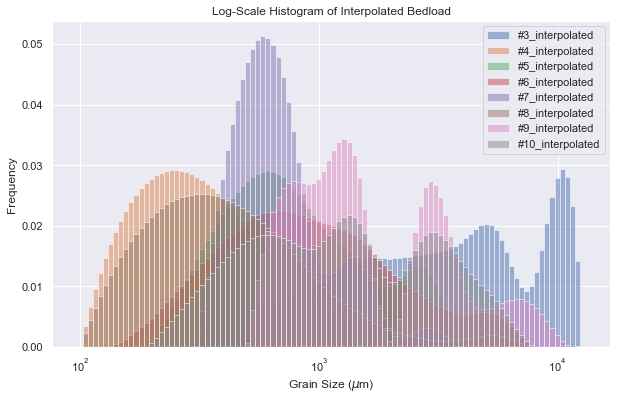

In [27]:
# calculate bin widths for log-scale histogram 
log_grain_sizes_interp = np.log10(d_interpolated)
bin_widths_interp = np.diff(log_grain_sizes_interp)
bin_widths_interp = np.append(bin_widths_interp, bin_widths_interp[-1])  # extend for last bin
actual_widths_interp = 10**(log_grain_sizes_interp + bin_widths_interp/2) - 10**(log_grain_sizes_interp - bin_widths_interp/2)

# plot as histogram
plt.figure(figsize=(10, 6))
for col in bedload_interpolated.columns[1:]:
    plt.bar(bedload_interpolated['grain_size'], bedload_interpolated[col], width=actual_widths_interp, 
            label=col, alpha=0.5)
plt.xscale('log')
plt.title('Log-Scale Histogram of Interpolated Bedload')
plt.xlabel('Grain Size ($\mu$m)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Fit KDE to interpolated sizes

In [28]:
for col in bedload_interpolated.columns[1:]:
    print(f"KDE for column: {col}")
    interpolated_percentages = bedload_interpolated[col].values
    # fit kde to the data
    log_grain_sizes_kde = np.log10(d_interpolated) # log-transform the grain sizes
    # create sample points weighted by their percentages for KDE
    sample_weights = (interpolated_percentages * 1000).astype(int)  # scale up and convert to int
    kde_samples = np.repeat(log_grain_sizes_kde, sample_weights)
    kde = gaussian_kde(kde_samples)
    # scale kde data to match the original
    log_x_smooth = np.linspace(log_grain_sizes_kde.min(), log_grain_sizes_kde.max(), 100)
    x_smooth = 10**log_x_smooth
    kde_density = kde(log_x_smooth)
    kde_density_scaled = kde_density * np.trapz(interpolated_percentages, log_grain_sizes_kde) / np.trapz(kde_density, log_x_smooth)
    # save the kde density to the dataframe
    bedload_interpolated[f'{col}_kde'] = kde_density_scaled

KDE for column: #3_interpolated
KDE for column: #4_interpolated
KDE for column: #5_interpolated
KDE for column: #6_interpolated
KDE for column: #7_interpolated
KDE for column: #8_interpolated
KDE for column: #9_interpolated
KDE for column: #10_interpolated


Plot and store KDEs for each sample

In [29]:
# loop through all interpolated samples and create plots
sns.set(style="darkgrid")
for col in bedload_interpolated.columns[1:]:
    if col.endswith('_interpolated'):  # just the interpolated columns
        kde_col = f'{col}_kde' # get the corresponding KDE column
        if kde_col in bedload_interpolated.columns:
            # get the data
            interpolated_percentages_sample = bedload_interpolated[col].values
            kde_density_scaled = bedload_interpolated[kde_col].values
            grain_sizes_sample = bedload_interpolated['grain_size'].values
            # create the plot
            plt.figure(figsize=(12, 6))
            # calculate bin widths for histogram
            log_grain_sizes_interp = np.log10(grain_sizes_sample)
            bin_widths_interp = np.diff(log_grain_sizes_interp)
            bin_widths_interp = np.append(bin_widths_interp, bin_widths_interp[-1])
            actual_widths_interp = 10**(log_grain_sizes_interp + bin_widths_interp/2) - 10**(log_grain_sizes_interp - bin_widths_interp/2)
            
            # plot histogram
            plt.bar(grain_sizes_sample, interpolated_percentages_sample, 
                    width=actual_widths_interp, alpha=0.7, label='Interpolated data', 
                    color='pink', edgecolor='black')
            # plot pre-calculated KDE curve
            plt.plot(grain_sizes_sample, kde_density_scaled, color='mediumvioletred', linewidth=3, label='KDE Fit', alpha=0.8)
            
            plt.xscale('log')
            plt.xlabel('Particle Size ($\mu$m)', fontsize=12)
            plt.ylabel('Percentage', fontsize=12)
            plt.title(f'Spring Bedload - Histogram with KDE Fit - {col}', fontsize=14)
            plt.grid(True, which="both", ls="--", alpha=0.3)
            plt.legend()
            plt.tight_layout()
            
            # save figure
            plt.savefig(f'bimodal_fit_plots/bedload_{col}_kde_fit.png', dpi=300, bbox_inches='tight')
            plt.close()  # Close the figure to free memory
        else:
            print(f"Warning: KDE column {kde_col} not found for {col}")


### Coarse Traps

Import data

In [35]:
trap_SM_coarse = pd.read_csv("SM23_coarse_trap_sediment.csv")
trap_SP_coarse = pd.read_csv("SP23_coarse_trap_sediment.csv")
grain_sizes = trap_SM_coarse['Di (um)'].values

In [36]:
# check the sum of columns (each sample percentage)
print("Sum (Trap SM):", trap_SM_coarse.iloc[:, 1:].sum())
print("Sum (Trap SP):", trap_SP_coarse.iloc[:, 1:].sum())

Sum (Trap SM): T1-A    1.0
T1-B    1.0
T1-C    1.0
T1-D    1.0
T2-A    1.0
T2-B    1.0
T3-C    1.0
T3-D    1.0
T5-A    1.0
T5-B    1.0
T5-C    1.0
T5-D    1.0
T6-B    1.0
T6-C    1.0
T6-D    1.0
T7-A    1.0
T7-B    1.0
T7-C    1.0
T7-D    1.0
T8-A    1.0
T8-C    1.0
T8-D    1.0
dtype: float64
Sum (Trap SP): T1-A    1.0
T1-B    1.0
T1-C    1.0
T1-D    1.0
T2-A    1.0
T2-B    1.0
T3-C    1.0
T3-D    1.0
T5-A    1.0
T5-B    1.0
T5-C    1.0
T5-D    1.0
T6-A    1.0
T6-B    1.0
T6-C    1.0
T6-D    1.0
T7-A    1.0
T7-B    1.0
T7-C    1.0
T7-D    1.0
T8-A    1.0
T8-C    1.0
T8-D    1.0
dtype: float64


Interpolate for all samples (traps)

In [40]:
# Initialize with the grain sizes - FIXED VERSION
grain_sizes = trap_SM_coarse['Di (um)'].values  # Use the actual grain sizes from data
log_grain_sizes = np.log(grain_sizes)
log_d_interpolated = np.linspace(log_grain_sizes.min(), log_grain_sizes.max(), 100)
d_interpolated = np.exp(log_d_interpolated)

trap_SM_coarse_interpolated = pd.DataFrame({'grain_size': d_interpolated})
trap_SP_coarse_interpolated = pd.DataFrame({'grain_size': d_interpolated})

# Loop through each sample column 
for col in trap_SM_coarse.columns[1:]:
    _, P_interpolated = interpolate_pdf_spline(grain_sizes, trap_SM_coarse[col])
    trap_SM_coarse_interpolated[f'{col}_interpolated'] = P_interpolated

for col in trap_SP_coarse.columns[1:]:
    _, P_interpolated = interpolate_pdf_spline(grain_sizes, trap_SP_coarse[col])
    trap_SP_coarse_interpolated[f'{col}_interpolated'] = P_interpolated

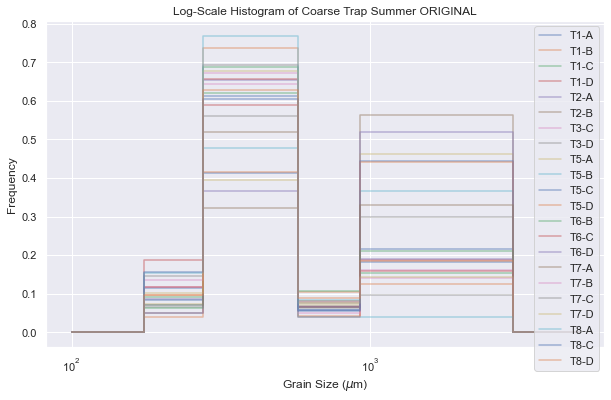

In [41]:
# plot as histogram
plt.figure(figsize=(10, 6))
for col in trap_SM_coarse.columns[1:]:
    plt.step(trap_SM_coarse['Di (um)'], trap_SM_coarse[col], where='mid',
            label=col, alpha=0.5)
plt.xscale('log')
plt.title('Log-Scale Histogram of Coarse Trap Summer ORIGINAL')
plt.xlabel('Grain Size ($\mu$m)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

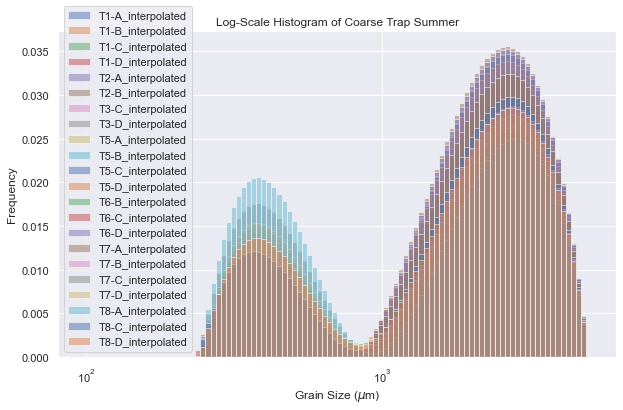

In [ ]:
# Calculate bin widths using theinterpolated grain sizes
log_grain_sizes_interp = np.log10(d_interpolated)  # Use d_interpolated, not the old variable
bin_widths_interp = np.diff(log_grain_sizes_interp)
bin_widths_interp = np.append(bin_widths_interp, bin_widths_interp[-1])
actual_widths_interp = 10**(log_grain_sizes_interp + bin_widths_interp/2) - 10**(log_grain_sizes_interp - bin_widths_interp/2)

# Plot as histogram
plt.figure(figsize=(10, 6))
for col in trap_SM_coarse_interpolated.columns[1:]:
    plt.bar(trap_SM_coarse_interpolated['grain_size'], trap_SM_coarse_interpolated[col], 
            width=actual_widths_interp, label=col, alpha=0.5)
plt.xscale('log')
plt.title('Log-Scale Histogram of Coarse Trap Summer')
plt.xlabel('Grain Size ($\mu$m)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

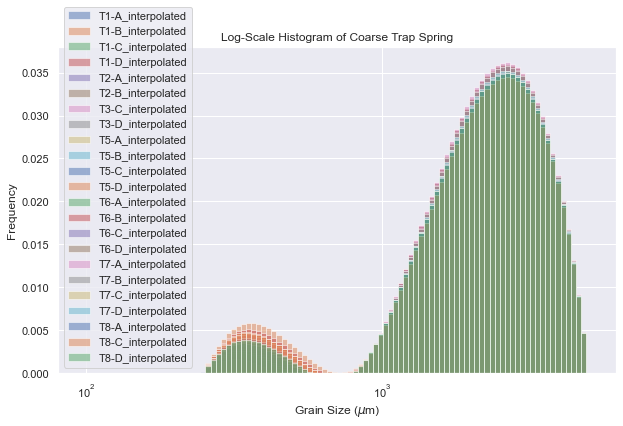

In [43]:
# plot as histogram
plt.figure(figsize=(10, 6))
for col in trap_SP_coarse_interpolated.columns[1:]:
    plt.bar(trap_SP_coarse_interpolated['grain_size'], trap_SP_coarse_interpolated[col], width=actual_widths_interp, 
            label=col, alpha=0.5)
plt.xscale('log')
plt.title('Log-Scale Histogram of Coarse Trap Spring')
plt.xlabel('Grain Size ($\mu$m)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [44]:
# check the sum of columns (each sample percentage)
print("Sum (Trap SM):", trap_SM_coarse_interpolated.iloc[:, 1:].sum())
print("Sum (Trap SP):", trap_SP_coarse_interpolated.iloc[:, 1:].sum())

Sum (Trap SM): T1-A_interpolated    1.0
T1-B_interpolated    1.0
T1-C_interpolated    1.0
T1-D_interpolated    1.0
T2-A_interpolated    1.0
T2-B_interpolated    1.0
T3-C_interpolated    1.0
T3-D_interpolated    1.0
T5-A_interpolated    1.0
T5-B_interpolated    1.0
T5-C_interpolated    1.0
T5-D_interpolated    1.0
T6-B_interpolated    1.0
T6-C_interpolated    1.0
T6-D_interpolated    1.0
T7-A_interpolated    1.0
T7-B_interpolated    1.0
T7-C_interpolated    1.0
T7-D_interpolated    1.0
T8-A_interpolated    1.0
T8-C_interpolated    1.0
T8-D_interpolated    1.0
dtype: float64
Sum (Trap SP): T1-A_interpolated    1.0
T1-B_interpolated    1.0
T1-C_interpolated    1.0
T1-D_interpolated    1.0
T2-A_interpolated    1.0
T2-B_interpolated    1.0
T3-C_interpolated    1.0
T3-D_interpolated    1.0
T5-A_interpolated    1.0
T5-B_interpolated    1.0
T5-C_interpolated    1.0
T5-D_interpolated    1.0
T6-A_interpolated    1.0
T6-B_interpolated    1.0
T6-C_interpolated    1.0
T6-D_interpolated    1.0
T7-A_

#### Summer

Fit KDE to the interpolated sizes

In [47]:
for col in trap_SM_coarse_interpolated.columns[1:]:
    print(f"KDE for column: {col}")
    interpolated_percentages = trap_SM_coarse_interpolated[col].values
    # fit kde to the data
    log_grain_sizes_kde = np.log10(d_interpolated) # log-transform the grain sizes
    # create sample points weighted by their percentages for KDE
    sample_weights = (interpolated_percentages * 1000).astype(int)
    kde_samples = np.repeat(log_grain_sizes_kde, sample_weights)
    kde = gaussian_kde(kde_samples)
    # scale kde data to match the original
    log_x_smooth = np.linspace(log_grain_sizes_kde.min(), log_grain_sizes_kde.max(), 100)
    x_smooth = 10**log_x_smooth
    kde_density = kde(log_x_smooth)
    kde_density_scaled = kde_density * np.trapz(interpolated_percentages, log_grain_sizes_kde) / np.trapz(kde_density, log_x_smooth)
    # save the kde density to the dataframe
    trap_SM_coarse_interpolated[f'{col}_kde'] = kde_density_scaled

KDE for column: T1-A_interpolated
KDE for column: T1-B_interpolated
KDE for column: T1-C_interpolated
KDE for column: T1-D_interpolated
KDE for column: T2-A_interpolated
KDE for column: T2-B_interpolated
KDE for column: T3-C_interpolated
KDE for column: T3-D_interpolated
KDE for column: T5-A_interpolated
KDE for column: T5-B_interpolated
KDE for column: T5-C_interpolated
KDE for column: T5-D_interpolated
KDE for column: T6-B_interpolated
KDE for column: T6-C_interpolated
KDE for column: T6-D_interpolated
KDE for column: T7-A_interpolated
KDE for column: T7-B_interpolated
KDE for column: T7-C_interpolated
KDE for column: T7-D_interpolated
KDE for column: T8-A_interpolated
KDE for column: T8-C_interpolated
KDE for column: T8-D_interpolated


Plot and store KDEs for each sample

In [ ]:
# loop through all interpolated samples and create plots
sns.set(style="darkgrid")
for col in trap_SM_coarse_interpolated.columns[1:]:
    if col.endswith('_interpolated'):  # just the interpolated columns
        kde_col = f'{col}_kde' # get the corresponding KDE column
        if kde_col in trap_SM_coarse_interpolated.columns:
            # get the data
            interpolated_percentages_sample = trap_SM_coarse_interpolated[col].values
            kde_density_scaled = trap_SM_coarse_interpolated[kde_col].values
            grain_sizes_sample = trap_SM_coarse_interpolated['grain_size'].values
            # create the plot
            plt.figure(figsize=(12, 6))
            # calculate bin widths for histogram
            log_grain_sizes_interp = np.log10(grain_sizes_sample)
            bin_widths_interp = np.diff(log_grain_sizes_interp)
            bin_widths_interp = np.append(bin_widths_interp, bin_widths_interp[-1])
            actual_widths_interp = 10**(log_grain_sizes_interp + bin_widths_interp/2) - 10**(log_grain_sizes_interp - bin_widths_interp/2)
            
            # plot histogram
            plt.bar(grain_sizes_sample, interpolated_percentages_sample, 
                    width=actual_widths_interp, alpha=0.7, label='Interpolated data', 
                    color='greenyellow', edgecolor='black')
            # plot pre-calculated KDE curve
            plt.plot(grain_sizes_sample, kde_density_scaled, color='darkolivegreen', linewidth=3, label='KDE Fit', alpha=0.8)
            
            plt.xscale('log')
            plt.xlabel('Particle Size ($\mu$m)', fontsize=12)
            plt.ylabel('Percentage', fontsize=12)
            plt.title(f'Summer - Coarse trap Histogram with KDE Fit - {col}', fontsize=14)
            plt.grid(True, which="both", ls="--", alpha=0.3)
            plt.legend()
            plt.tight_layout()
            
            # save figure
            plt.savefig(f'bimodal_fit_plots/coarse_traps/SM_{col}_kde_fit.png', dpi=300, bbox_inches='tight')
            plt.close()  # Close the figure to free memory
        else:
            print(f"Warning: KDE column {kde_col} not found for {col}")

In [49]:
# print the sum of the kde densities
for col in trap_SM_coarse_interpolated.columns[1:]:
    if col.endswith('_kde'):
        kde_sum = trap_SM_coarse_interpolated[col].sum()
        print(f"Sum of {col}: {kde_sum}")

Sum of T1-A_interpolated_kde: 1.0034572120219227
Sum of T1-B_interpolated_kde: 1.003508337028981
Sum of T1-C_interpolated_kde: 1.0034742126460556
Sum of T1-D_interpolated_kde: 1.0034726936132605
Sum of T2-A_interpolated_kde: 1.0034285799941707
Sum of T2-B_interpolated_kde: 1.0025666756590863
Sum of T3-C_interpolated_kde: 1.0033732451626387
Sum of T3-D_interpolated_kde: 1.003352599957499
Sum of T5-A_interpolated_kde: 1.0028179563445558
Sum of T5-B_interpolated_kde: 1.0031231370738978
Sum of T5-C_interpolated_kde: 1.002871618958109
Sum of T5-D_interpolated_kde: 1.0029632259188273
Sum of T6-B_interpolated_kde: 1.0033781941521724
Sum of T6-C_interpolated_kde: 1.003468516350846
Sum of T6-D_interpolated_kde: 1.002696180740401
Sum of T7-A_interpolated_kde: 1.003246847292062
Sum of T7-B_interpolated_kde: 1.0034971627001874
Sum of T7-C_interpolated_kde: 1.003334377516069
Sum of T7-D_interpolated_kde: 1.0033610223537146
Sum of T8-A_interpolated_kde: 1.0033310377882096
Sum of T8-C_interpolated_kd

#### Spring

Fit KDE to the interpolated sizes

In [50]:
for col in trap_SP_coarse_interpolated.columns[1:]:
    print(f"KDE for column: {col}")
    interpolated_percentages = trap_SP_coarse_interpolated[col].values
    # fit kde to the data
    log_grain_sizes_kde = np.log10(interpolated_grain_sizes) # log-transform the grain sizes
    # create sample points weighted by their percentages for KDE
    sample_weights = (interpolated_percentages * 1000).astype(int)  # scale up and convert to int
    kde_samples = np.repeat(log_grain_sizes_kde, sample_weights)
    kde = gaussian_kde(kde_samples)
    # scale kde data to match the original
    log_x_smooth = np.linspace(log_grain_sizes_kde.min(), log_grain_sizes_kde.max(), 100)
    x_smooth = 10**log_x_smooth
    kde_density = kde(log_x_smooth)
    kde_density_scaled = kde_density * np.trapz(interpolated_percentages, log_grain_sizes_kde) / np.trapz(kde_density, log_x_smooth)

    # save the kde density to the dataframe
    trap_SP_coarse_interpolated[f'{col}_kde'] = kde_density_scaled

KDE for column: T1-A_interpolated
KDE for column: T1-B_interpolated
KDE for column: T1-C_interpolated
KDE for column: T1-D_interpolated
KDE for column: T2-A_interpolated
KDE for column: T2-B_interpolated
KDE for column: T3-C_interpolated
KDE for column: T3-D_interpolated
KDE for column: T5-A_interpolated
KDE for column: T5-B_interpolated
KDE for column: T5-C_interpolated
KDE for column: T5-D_interpolated
KDE for column: T6-A_interpolated
KDE for column: T6-B_interpolated
KDE for column: T6-C_interpolated
KDE for column: T6-D_interpolated
KDE for column: T7-A_interpolated
KDE for column: T7-B_interpolated
KDE for column: T7-C_interpolated
KDE for column: T7-D_interpolated
KDE for column: T8-A_interpolated
KDE for column: T8-C_interpolated
KDE for column: T8-D_interpolated


Plot and store KDEs for each sample

In [ ]:
# loop through all interpolated samples and create plots
sns.set(style="darkgrid")
for col in trap_SP_coarse_interpolated.columns[1:]:
    if col.endswith('_interpolated'):  # just the interpolated columns
        kde_col = f'{col}_kde' # get the corresponding KDE column
        if kde_col in trap_SP_coarse_interpolated.columns:
            # get the data
            interpolated_percentages_sample = trap_SP_coarse_interpolated[col].values
            kde_density_scaled = trap_SP_coarse_interpolated[kde_col].values
            grain_sizes_sample = trap_SP_coarse_interpolated['grain_size'].values
            # create the plot
            plt.figure(figsize=(12, 6))
            # calculate bin widths for histogram
            log_grain_sizes_interp = np.log10(grain_sizes_sample)
            bin_widths_interp = np.diff(log_grain_sizes_interp)
            bin_widths_interp = np.append(bin_widths_interp, bin_widths_interp[-1])
            actual_widths_interp = 10**(log_grain_sizes_interp + bin_widths_interp/2) - 10**(log_grain_sizes_interp - bin_widths_interp/2)
            
            # plot histogram
            plt.bar(grain_sizes_sample, interpolated_percentages_sample, 
                    width=actual_widths_interp, alpha=0.7, label='Interpolated data', 
                    color='paleturquoise', edgecolor='black')
            # plot pre-calculated KDE curve
            plt.plot(grain_sizes_sample, kde_density_scaled, color='darkcyan', linewidth=3, label='KDE Fit', alpha=0.8)

            plt.xscale('log')
            plt.xlabel('Particle Size ($\mu$m)', fontsize=12)
            plt.ylabel('Percentage', fontsize=12)
            plt.title(f'Spring - Coarse trap Histogram with KDE Fit - {col}', fontsize=14)
            plt.grid(True, which="both", ls="--", alpha=0.3)
            plt.legend()
            plt.tight_layout()
            
            # save figure
            plt.savefig(f'bimodal_fit_plots/coarse_traps/SP_{col}_kde_fit.png', dpi=300, bbox_inches='tight')
            plt.close()  # Close the figure to free memory
        else:
            print(f"Warning: KDE column {kde_col} not found for {col}")